# 🛠️ <strong> Hands-On Exercise: Air Traffic Scenario Generation with LLMs</strong>

---

## 🧩 Problem Introduction

This exercise focuses on the **generation of synthetic air traffic scenarios** using **Large Language Models (LLMs)**. Participants will explore how to leverage LLMs to create realistic and coherent air traffic scenario data, simulating operational airspace environments for downstream applications such as simulation, training, or decision-support systems.

---

## 📌 Case Study Objective

**Problem Statement**: Develop a methodology for generating structured air traffic scenarios using LLMs. The scenarios should reflect realistic airspace configurations and flight operations.

---

## 🎯 Goal

By the end of this exercise, you should be able to:
- Understand the constraints and data requirements for air traffic scenario generation
- Apply LLMs to produce plausible traffic configurations
- Evaluate output quality with respect to domain validity

---

## 🔧 <strong>Requirements</strong>

### ✈️ Domain Information
* Airspace layout: Since we want to generate scenarios in sector 6 of the Singapore FIR, we need information of the waypoints, airways, etc
* Aircraft types to be used
* Traffic rules and constraints (e.g., separation minima)


### ❗ Model Considerations
* Choice of LLM
  * Model size
  * Capability and token limits
* Access type: API usage vs local deployment
* Fine-tuning:
  * Whether fine-tuning is needed
  * Dataset availability and preprocessing
  * Cost implications (hardware, compute time)

### 🛠️ <strong>Alternative Approaches</strong>
* Prompt engineering with few-shot examples
* Retrieval-augmented generation (RAG)
* Use of domain-specific templates or grammars

---



## ⏩  Current exercise:
## 🔧 Adapting Generalized LLMs to Domain-Specific Use Cases

- While **general-purpose LLMs** are powerful, adapting them to specific domains often requires **fine-tuning**.
  - However, fine-tuning is **data-intensive**, and labeled data in specialized domains (e.g., air traffic) is often **scarce**.
  - Additionally, the process is **computationally expensive** and requires significant hardware resources.

- 🔸 **Retrieval-Augmented Generation (RAG)** offers an alternative 🔸 :
  - Allows LLMs to **retrieve external domain-specific knowledge** at inference time.
  - Does **not require modifying model parameters**.
  - Helps in **reducing hallucinations** by grounding responses in factual or curated sources.
  - Enables **easier domain customization** and keeps models **up-to-date** with evolving data.

---

> ✅ **Summary**: RAG provides a cost-effective and flexible way to specialize LLMs for domain-specific tasks when fine-tuning is impractical.

## 🚀 Steps to Perform

**1. 🛠️ Initial Setup**  
   - 📂 Mount Google Drive to access required content.  
   - 📦 Install dependencies needed to run the models (e.g., Ollama, LangChain, ChromaDB).  
   - 🐍 Import necessary Python libraries.  
   - 💻 Set up and initialize Ollama via the terminal in Google Colab.

**2. 🧩 Define Helper Functions for Post-processing LLM Output**  
   *Purpose:*  
   - 📝 Convert the model output (string) into a Python dictionary.  
   - 🧺 Extract relevant fields and generate structured output (e.g., XML) for use in simulation tools like **NARSIM**.

**3. Set up the retrieval augmented generation functionality**
   - work with Recursive character text splitter to chunk the documents.
   - set up the Chroma database and the retriver that will check the similarity of the chunks with the prompt, and give relevant chunks from the document.

**4. 🧠 Customize the Language Model**  
   - Test a model with high level guidance on the task only.
   - Design a "good" system message that describes the role and purpose, data and constraints, other relevant guidance points.
   -




## **1. 🛠️ Initial Setup**

### Mounting One-drive

In [59]:
from google.colab import drive
drive.mount('/content/drive')      # prompts for authorization


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installing dependencies

In [2]:
!pip install streamlit pdfplumber ollama chromadb langchain langchain_community pytesseract langchain-cohere langchain_experimental gradio ollama unstructured pdfminer.six pi_heif unstructured_inference --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 48.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
#importing necessary libraries

from nltk.tokenize import sent_tokenize
import xml.etree.ElementTree as ET
import xml.dom.minidom
# import streamlit as st
import logging
import os
import tempfile
import shutil
import pdfplumber
import ollama
import re
import gradio as gr
import json
import random
import chromadb
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_community.embeddings import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate, PromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_community.chat_models import ChatOllama
from langchain_cohere import ChatCohere
from langchain_core.runnables import RunnablePassthrough
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.chains import RetrievalQA, ConversationalRetrievalChain, create_history_aware_retriever, create_retrieval_chain
from langchain.memory import ConversationBufferMemory
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.document_loaders import TextLoader, PyPDFLoader
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from typing import List, Tuple, Dict, Any, Optional
import pytesseract

In [4]:
import os
os.getcwd()

'/content'

In [60]:
cd '/content/drive/MyDrive/LLMtutorial'

/content/drive/MyDrive/LLMtutorial


In [6]:
os.getcwd()

'/content/drive/MyDrive/LLMtutorial'

In [7]:
!pip install colab-xterm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 9.7 MB/s eta 0:00:00


In [8]:
%load_ext colabxterm

In [9]:
!curl https://ollama.ai/install.sh | sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13281    0 13281    0     0  20935      0 --:--:-- --:--:-- --:--:-- 20914
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [33]:
%xterm #run "ollama serve" in the terminal below


Launching Xterm...

<IPython.core.display.Javascript object>

In [34]:
!ollama pull mxbai-embed-large # install an embedding model from ollama

## **2. 🧩 Define Helper Functions for Post-processing LLM Output**  

In [35]:
#######################################################################
# Extracts json markdown (string) from the chatbot output and turns it form a string to JSON dictionary
def str2dict(response):
    pattern = r"```json\n(.*?)\n```"
    matches = re.findall(pattern, response, re.DOTALL)
    # print(f"Matches found: {matches}")

    if not matches:
        return 'No valid ouput'

    json_str = ' '.join(matches)
    try:
        json_d = json.loads(json_str)
        print(f"Parsed JSON: {json_d}")
    except (json.JSONDecodeError, IndexError) as e:
        print(f"Error parsing JSON: {e}")
        return 'No valid output'

    return json_d



In [36]:
#Post Processing step to fill in the full xml required for NARSIM
def json_to_xml(json_data):
    if json_data == 'No valid ouput':
        return '"No valid output"'
    waket = {'A320': 'MEDIUM', 'B738': 'MEDIUM', 'B737': 'MEDIUM', 'B744': 'HEAVY',
             'B734': 'MEDIUM', 'A388': 'HEAVY', 'A333': 'HEAVY'}
    # Create the root element <ifp>
    root_ifp = ET.Element("ifp")

    # Add experiment-date element
    experiment_date = ET.SubElement(root_ifp, "experiment-date")
    day = ET.SubElement(experiment_date, "day")
    day.text = '6'
    month = ET.SubElement(experiment_date, "month")
    month.text = '3'
    year = ET.SubElement(experiment_date, "year")
    year.text = '2022'

    # Add experiment-time element
    experiment_time = ET.SubElement(root_ifp, "experiment-time")
    experiment_time.text = '00000'

    # Add default-equipment element
    default_equipment = ET.SubElement(root_ifp, "default-equipment")
    default_equipment.text = "SSR_MODE_A+SSR_MODE_C+P_RNAV+FMS+FMS_GUIDANCE_VNAV+FMS_GUIDANCE_SPEED"

    for i, item in enumerate(json_data.values()):
        if isinstance(item, str) and " " in item:
            # Remove all spaces in the string
            item = item.replace(" ", "")
        # Create the initial-flightplans element
        initial_flightplans = ET.SubElement(
            root_ifp, "initial-flightplans", key="initial-flightplans:"+str(i))

        usage = ET.SubElement(initial_flightplans, "usage")
        usage.text = "ALL"
        time = ET.SubElement(initial_flightplans, "time")
        time.text = str(item["time"])  # From model
        callsign = ET.SubElement(initial_flightplans, "callsign")
        callsign.text = "SQ1"+str(i)
        rules = ET.SubElement(initial_flightplans, "rules")
        squawk = ET.SubElement(initial_flightplans, "squawk", units="octal")
        squawk.text = ''.join(str(random.randint(0, 7)) for _ in range(4))
        aircraft_type = ET.SubElement(initial_flightplans, "type")
        aircraft_type.text = item["type"]  # From model
        waketurb = ET.SubElement(initial_flightplans, "waketurb")
        waketurb.text = waket[item["type"]]
        equip = ET.SubElement(initial_flightplans, "equip")
        vehicle_type = ET.SubElement(initial_flightplans, "vehicle_type")

        dep = ET.SubElement(initial_flightplans, "dep")
        dep_af = ET.SubElement(dep, "af")
        dep_af.text = item["departure"]["af"]  # From model
        dep_rwy = ET.SubElement(dep, "rwy")

        des = ET.SubElement(initial_flightplans, "des")
        des_af = ET.SubElement(des, "af")
        des_af.text = item["destination"]["af"]  # From model

        for route in item["air_route"]:
            air_route = ET.SubElement(initial_flightplans, "air_route")
            air_route.text = route

        rfl = ET.SubElement(initial_flightplans, "rfl")
        rfl.text = '300'
        init = ET.SubElement(initial_flightplans, "init")
        pos = ET.SubElement(init, "pos")
        lat = ET.SubElement(pos, "lat")
        lat.text = item["initial_position"]["latitude"]  # From model
        lon = ET.SubElement(pos, "lon")
        lon.text = item["initial_position"]["longitude"]  # From model

        freq = ET.SubElement(init, "freq")
        freq.text = 'SINRADS1'
        alt = ET.SubElement(
            init, "alt", units=item["initial_position"]["altitude"][:2])
        alt.text = item["initial_position"]["altitude"][2:]  # From model
        hdg = ET.SubElement(init, "hdg")
        hdg.text = str(item["initial_position"]["heading"])

    # Convert the tree to a string
    xdat_content = ET.tostring(
        root_ifp, encoding='UTF-8', xml_declaration=True)
    # print(xdat_content)
    dom = xml.dom.minidom.parseString(xdat_content)
    pretty_xdat = dom.toprettyxml()

    return pretty_xdat

## **3. Set up the retrieval augmented generation functionality**

In [37]:
#use this to delete the database if a fresh conversation is required
vector_db.delete_collection()

In [38]:
memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")
path = 'Data_bundlefinal2_6jan2025.pdf'
loader = PyPDFLoader(path)
data = loader.load()
text_splitter = RecursiveCharacterTextSplitter(separators=["-----------", "\n\n", "\n"],
                                                chunk_size=550, chunk_overlap=100)
chunks = text_splitter.split_documents(data)
embeddings = OllamaEmbeddings(
    model="mxbai-embed-large", show_progress=True)
vector_db = Chroma.from_documents(
    documents=chunks, embedding=embeddings, collection_name="myRAG"
)
retriever = vector_db.as_retriever(
        search_type="mmr", search_kwargs={"fetch_k": 28, "k": 16, "lambda_mult": 0.6})
def format_docs(docs):
        # st.write("\n\n".join(doc.page_content for doc in docs))
        # , "\n\n".join(doc.page_content for doc in docs[:3])
        return "\n\n".join(doc.page_content for doc in docs)
    # formatted_docs, extracted_context = format_docs(extracted_docs)



OllamaEmbeddings: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


## **4. 🧠 Customize the Language Model**  

**Choice of models** \\
 - command-r7b-12-2024 \\
 - command-a-03-2025

### **Phase1**: Calling a LLM with no additional infromation on the requirements, and a simple system message

In [16]:
chatbot_history = []
llm = ChatCohere(cohere_api_key="njPNUMUWPRMIoHRPoV8xSJvucU2sEZw99puyga7r",
                     model="command-r7b-12-2024", temperature=0, streaming=True,
                     preamble="""You are an AI system that generates traffic scenarios for a simulator. Based on the user input, generate the user defined scenario in json format. Use the information retrieved from the document to generate the scenario in sector 6.
                   """)

prompt = ChatPromptTemplate.from_messages(
      [
            MessagesPlaceholder(variable_name="chat_history"),

            ("human", """User prompt: {question}
                      """),
        ]
    )

chain = (
        prompt
        | llm
        | StrOutputParser()
    )

In [17]:
question = 'Generate 3 aircraft on airway M758, airway N884 and airway M761. The aircraft should be separated by 200 seconds with the first aircraft starting at 100 seconds.'
extracted_docs = retriever.invoke(question) # performs semantic search of the knowledge base based on the question
formatted_docs = format_docs(extracted_docs)
response = chain.invoke({"context": formatted_docs, "chat_history": chatbot_history, "question": question})
response

OllamaEmbeddings: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


'```json\n{\n  "airways": [\n    {\n      "airway": "M758",\n      "aircraft": [\n        {\n          "id": 1,\n          "type": "Boeing 737-800",\n          "start_time": 100,\n          "position": "Takeoff from LAX"\n        },\n        {\n          "id": 2,\n          "type": "Airbus A320",\n          "start_time": 300,\n          "position": "Over the Pacific Ocean"\n        },\n        {\n          "id": 3,\n          "type": "Embraer E195",\n          "start_time": 500,\n          "position": "Approaching San Francisco International Airport"\n        }\n      ]\n    },\n    {\n      "airway": "N884",\n      "aircraft": [\n        {\n          "id": 4,\n          "type": "Boeing 777-200ER",\n          "start_time": 100,\n          "position": "Taking off from New York JFK"\n        },\n        {\n          "id": 5,\n          "type": "Airbus A350-900",\n          "start_time": 300,\n          "position": "Over the Atlantic Ocean"\n        },\n        {\n          "id": 6,\n    

In [18]:
a = str2dict(response=response)
a

Parsed JSON: {'airways': [{'airway': 'M758', 'aircraft': [{'id': 1, 'type': 'Boeing 737-800', 'start_time': 100, 'position': 'Takeoff from LAX'}, {'id': 2, 'type': 'Airbus A320', 'start_time': 300, 'position': 'Over the Pacific Ocean'}, {'id': 3, 'type': 'Embraer E195', 'start_time': 500, 'position': 'Approaching San Francisco International Airport'}]}, {'airway': 'N884', 'aircraft': [{'id': 4, 'type': 'Boeing 777-200ER', 'start_time': 100, 'position': 'Taking off from New York JFK'}, {'id': 5, 'type': 'Airbus A350-900', 'start_time': 300, 'position': 'Over the Atlantic Ocean'}, {'id': 6, 'type': 'Boeing 787-9', 'start_time': 500, 'position': 'Approaching London Heathrow Airport'}]}, {'airway': 'M761', 'aircraft': [{'id': 7, 'type': 'Airbus A321neo', 'start_time': 100, 'position': "Taking off from Chicago O'Hare"}, {'id': 8, 'type': 'Boeing 737 MAX 8', 'start_time': 300, 'position': 'Over the Midwest'}, {'id': 9, 'type': 'Embraer E175', 'start_time': 500, 'position': 'Approaching Bosto

{'airways': [{'airway': 'M758',
   'aircraft': [{'id': 1,
     'type': 'Boeing 737-800',
     'start_time': 100,
     'position': 'Takeoff from LAX'},
    {'id': 2,
     'type': 'Airbus A320',
     'start_time': 300,
     'position': 'Over the Pacific Ocean'},
    {'id': 3,
     'type': 'Embraer E195',
     'start_time': 500,
     'position': 'Approaching San Francisco International Airport'}]},
  {'airway': 'N884',
   'aircraft': [{'id': 4,
     'type': 'Boeing 777-200ER',
     'start_time': 100,
     'position': 'Taking off from New York JFK'},
    {'id': 5,
     'type': 'Airbus A350-900',
     'start_time': 300,
     'position': 'Over the Atlantic Ocean'},
    {'id': 6,
     'type': 'Boeing 787-9',
     'start_time': 500,
     'position': 'Approaching London Heathrow Airport'}]},
  {'airway': 'M761',
   'aircraft': [{'id': 7,
     'type': 'Airbus A321neo',
     'start_time': 100,
     'position': "Taking off from Chicago O'Hare"},
    {'id': 8,
     'type': 'Boeing 737 MAX 8',
     

In [21]:
# check what the retriever has provided (we have change the number of chunks which are currently set to 4)
print(formatted_docs)

NameError: name 'formatted_docs' is not defined

### **Phase2**: Calling an LLM with a constructed system message

Key considerations:
*   specific requirements.
*   output structure definition.
*   Constraints





In [44]:
vector_db.delete_collection()

memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")
path = 'Data_bundlefinal2_6jan2025.pdf'
loader = PyPDFLoader(path)
data = loader.load()
text_splitter = RecursiveCharacterTextSplitter(separators=["-----------", "\n\n", "\n"],
                                                chunk_size=550, chunk_overlap=100)
chunks = text_splitter.split_documents(data)
embeddings = OllamaEmbeddings(
    model="mxbai-embed-large", show_progress=True)
vector_db = Chroma.from_documents(
    documents=chunks, embedding=embeddings, collection_name="myRAG"
)
retriever = vector_db.as_retriever(
        search_type="mmr", search_kwargs={"fetch_k": 28, "k": 16, "lambda_mult": 0.6})
def format_docs(docs):
        # st.write("\n\n".join(doc.page_content for doc in docs))
        # , "\n\n".join(doc.page_content for doc in docs[:3])
        return "\n\n".join(doc.page_content for doc in docs)
    # formatted_docs, extracted_context = format_docs(extracted_docs)


OllamaEmbeddings: 100%|██████████| 20/20 [00:00<00:00, 23.90it/s]


In [45]:
chatbot_history = []
llm = ChatCohere(cohere_api_key="njPNUMUWPRMIoHRPoV8xSJvucU2sEZw99puyga7r",
                     model="command-r7b-12-2024", temperature=0, streaming=True,
                     preamble="""You are an AI system that generates traffic scenarios for a simulator.
                    - When the user requests for a scenario, strictly give the output in JSON based on schema_1, otherwise reply normally.
                    - Do not output a list.
                    - Refer to the chat_history to understand the context of the conversation before replying.
                    - Use complete air_routes from the Data Bundle when generating outputs.
                    - Follow the separation time provided by use. Otherwise, ensure that the aircraft are separated by a minimum time 100 seconds.
                    - IMPORTANT: ENSURE TO USE THE AIRWAYS SPECIFIED IN THE PROMPT.
                    - Some airways have reversed orders also. Do not confuse this. For example: M758 is different from M758R.

                    ----------------------------------------
                        schema_1:
                        {
                        "aircraft 1": {
                        "departure": {
                        "af": "ICAO code of departure airfield here"
                        },
                        "initial_position": {
                        "latitude": "latitude in DMS format for example 023106.70N",
                        "longitude": "latitude in DMS format for example 1035709.81E",
                        "altitude": " initial flight level / initial Altitude reading, for example FL300",
                        "heading": "heading in degrees for example 32.05"
                        },
                        "air_route": "list of waypoints that make up the air route, for example ["RAXIM", "OTLON", "VISAT", "DUBSA", "DAMOG", "DOLOX", "DUDIS"]",
                        "destination": {
                        "af": "ICAO code of destination airfield here"
                        },
                        "time": "starting time of aircraft initialization in the simulator as an integer representing seconds, for example 300",
                        "type": "type of aircraft, for example A320",
                        "rfl": "Final flight level of the aircraft",},
                        "aircraft 2": {},
                        "aircraft n": {},
                        }
                        where n is the number of aircraft in the scenario.

                    ---------------------------------------------
                    Only use the Available Aircraft Types:
                    • A320
                    • B737
                    • B738
                    • B734
                    • B744
                    • A388
                    • A333

                    ---------------------------------------------
                   If the number of aircraft are not specified, use the following range:
                   • Type 1 traffic density: 1 to 4 aircraft.
                   • Type 2 traffic density: 5 to 9 aircraft.
                   • Type 3 traffic density: 10 to 20 aircraft.
                   Otherwise, ensure to generate the same number of aircraft that are specified.""")

prompt = ChatPromptTemplate.from_messages(
      [
            MessagesPlaceholder(variable_name="chat_history"),

            ("human", """User prompt: {question}
                        --------------------------------------------
                        The Data bundle contains examples of airways, along with their corresponding list of waypoints that define the air routes for each airway. When creating scenarios, refer to these examples and ensure to match the complete list of waypoints provided for each respective airway.

                        Data bundle: {context}
                       """),
        ]
    )

chain = (
        prompt
        | llm
        | StrOutputParser()
    )

In [53]:
question = 'Generate a 2 aircraft scenario. Aircraft 1 on airway M758 and  aircraft 2 on airway N884. The first aircraft should start at time 100 seconds and the second aircraft starting at 300 seconds.'
extracted_docs = retriever.invoke(question) # performs semantic search of the knowledge base based on the question
formatted_docs = format_docs(extracted_docs)
response = chain.invoke({"context": formatted_docs, "chat_history": chatbot_history, "question": question})
response


OllamaEmbeddings: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


'```json\n{\n  "aircraft 1": {\n    "departure": {\n      "af": "WMKK"\n    },\n    "initial_position": {\n      "latitude": "032432.00N",\n      "longitude": "1035544.00E",\n      "altitude": "FL370",\n      "heading": "87.11"\n    },\n    "air_route": ["IDSEL", "URIGO", "VISAT", "MABAL", "ELGOR", "OPULA", "LUSMO"],\n    "destination": {\n      "af": "WBKK"\n    },\n    "time": 100,\n    "type": "A320",\n    "rfl": "FL370"\n  },\n  "aircraft 2": {\n    "departure": {\n      "af": "WSSS"\n    },\n    "initial_position": {\n      "latitude": "022318.00N",\n      "longitude": "1035218.00E",\n      "altitude": "FL400",\n      "heading": "65"\n    },\n    "air_route": ["VMR", "LENDA", "LIPRO", "LEBIN", "ONAPO", "LUSMO"],\n    "destination": {\n      "af": "WBKK"\n    },\n    "time": 300,\n    "type": "B738",\n    "rfl": "FL400"\n  }\n}\n```'

In [54]:
a = str2dict(response=response)
a

Parsed JSON: {'aircraft 1': {'departure': {'af': 'WMKK'}, 'initial_position': {'latitude': '032432.00N', 'longitude': '1035544.00E', 'altitude': 'FL370', 'heading': '87.11'}, 'air_route': ['IDSEL', 'URIGO', 'VISAT', 'MABAL', 'ELGOR', 'OPULA', 'LUSMO'], 'destination': {'af': 'WBKK'}, 'time': 100, 'type': 'A320', 'rfl': 'FL370'}, 'aircraft 2': {'departure': {'af': 'WSSS'}, 'initial_position': {'latitude': '022318.00N', 'longitude': '1035218.00E', 'altitude': 'FL400', 'heading': '65'}, 'air_route': ['VMR', 'LENDA', 'LIPRO', 'LEBIN', 'ONAPO', 'LUSMO'], 'destination': {'af': 'WBKK'}, 'time': 300, 'type': 'B738', 'rfl': 'FL400'}}


{'aircraft 1': {'departure': {'af': 'WMKK'},
  'initial_position': {'latitude': '032432.00N',
   'longitude': '1035544.00E',
   'altitude': 'FL370',
   'heading': '87.11'},
  'air_route': ['IDSEL', 'URIGO', 'VISAT', 'MABAL', 'ELGOR', 'OPULA', 'LUSMO'],
  'destination': {'af': 'WBKK'},
  'time': 100,
  'type': 'A320',
  'rfl': 'FL370'},
 'aircraft 2': {'departure': {'af': 'WSSS'},
  'initial_position': {'latitude': '022318.00N',
   'longitude': '1035218.00E',
   'altitude': 'FL400',
   'heading': '65'},
  'air_route': ['VMR', 'LENDA', 'LIPRO', 'LEBIN', 'ONAPO', 'LUSMO'],
  'destination': {'af': 'WBKK'},
  'time': 300,
  'type': 'B738',
  'rfl': 'FL400'}}

In [55]:
# check what the retriever retrieved from the document
print(formatted_docs)

2. Airway M758R
{
"time": "Initialization time of aircraft after simulation start in seconds",
"type": "B744",
"departure": {
"af": "WBKK"
},
"initial_position": {
"latitude": "033341.00N",
"longitude": "1065534.00E ",
"altitude": "FL340",
"heading": "270”
},
"air_route": [ "LUSMO", "OPULA", "ELGOR", "MABAL", "VISAT", "URIGO",
"IDSEL", "PADLI", “SAROX”],
"destination": {
"af": "WMKK"
}
}
-----------

10. Airway N884
{  
"time": "Initialization time of aircraft after simulation start in seconds",  
"type": "B738",  
"departure": {  
"af": "WSSS"  
},  
"initial_position": {  
"latitude": "022318.00N",  
"longitude": "1035218.00E ",  
"altitude": "FL400",  
"heading": "65"  
},  
"air_route": ["VMR", "LENDA", "LIPRO", "LEBIN", "ONAPO", "LUSMO"],  
"destination": {  
"af": "WBKK"  
}  
}
-----------

11. Airway N875
{  
"time": "Initialization time of aircraft after simulation start in seconds",  
"type": "B738",  
"departure": {  
"af": "VDPP"  
},  
"initial_position": {  
"latitude": "

In [64]:
b = json_to_xml(a)
b

'<?xml version="1.0" ?>\n<ifp>\n\t<experiment-date>\n\t\t<day>6</day>\n\t\t<month>3</month>\n\t\t<year>2022</year>\n\t</experiment-date>\n\t<experiment-time>00000</experiment-time>\n\t<default-equipment>SSR_MODE_A+SSR_MODE_C+P_RNAV+FMS+FMS_GUIDANCE_VNAV+FMS_GUIDANCE_SPEED</default-equipment>\n\t<initial-flightplans key="initial-flightplans:0">\n\t\t<usage>ALL</usage>\n\t\t<time>100</time>\n\t\t<callsign>SQ10</callsign>\n\t\t<rules/>\n\t\t<squawk units="octal">5703</squawk>\n\t\t<type>A320</type>\n\t\t<waketurb>MEDIUM</waketurb>\n\t\t<equip/>\n\t\t<vehicle_type/>\n\t\t<dep>\n\t\t\t<af>WMKK</af>\n\t\t\t<rwy/>\n\t\t</dep>\n\t\t<des>\n\t\t\t<af>WBKK</af>\n\t\t</des>\n\t\t<air_route>IDSEL</air_route>\n\t\t<air_route>URIGO</air_route>\n\t\t<air_route>VISAT</air_route>\n\t\t<air_route>MABAL</air_route>\n\t\t<air_route>ELGOR</air_route>\n\t\t<air_route>OPULA</air_route>\n\t\t<air_route>LUSMO</air_route>\n\t\t<rfl>300</rfl>\n\t\t<init>\n\t\t\t<pos>\n\t\t\t\t<lat>032432.00N</lat>\n\t\t\t\t<lon>1

#### **The output that is required by the Simulator**

In [57]:
from IPython.display import display, Markdown
xml_content = Markdown(f"```xml\n{b}\n```")
display(Markdown(f"```xml\n{b}\n```"))

```xml
<?xml version="1.0" ?>
<ifp>
	<experiment-date>
		<day>6</day>
		<month>3</month>
		<year>2022</year>
	</experiment-date>
	<experiment-time>00000</experiment-time>
	<default-equipment>SSR_MODE_A+SSR_MODE_C+P_RNAV+FMS+FMS_GUIDANCE_VNAV+FMS_GUIDANCE_SPEED</default-equipment>
	<initial-flightplans key="initial-flightplans:0">
		<usage>ALL</usage>
		<time>100</time>
		<callsign>SQ10</callsign>
		<rules/>
		<squawk units="octal">0752</squawk>
		<type>A320</type>
		<waketurb>MEDIUM</waketurb>
		<equip/>
		<vehicle_type/>
		<dep>
			<af>WMKK</af>
			<rwy/>
		</dep>
		<des>
			<af>WBKK</af>
		</des>
		<air_route>IDSEL</air_route>
		<air_route>URIGO</air_route>
		<air_route>VISAT</air_route>
		<air_route>MABAL</air_route>
		<air_route>ELGOR</air_route>
		<air_route>OPULA</air_route>
		<air_route>LUSMO</air_route>
		<rfl>300</rfl>
		<init>
			<pos>
				<lat>032432.00N</lat>
				<lon>1035544.00E</lon>
			</pos>
			<freq>SINRADS1</freq>
			<alt units="FL">370</alt>
			<hdg>87.11</hdg>
		</init>
	</initial-flightplans>
	<initial-flightplans key="initial-flightplans:1">
		<usage>ALL</usage>
		<time>300</time>
		<callsign>SQ11</callsign>
		<rules/>
		<squawk units="octal">4766</squawk>
		<type>B738</type>
		<waketurb>MEDIUM</waketurb>
		<equip/>
		<vehicle_type/>
		<dep>
			<af>WSSS</af>
			<rwy/>
		</dep>
		<des>
			<af>WBKK</af>
		</des>
		<air_route>VMR</air_route>
		<air_route>LENDA</air_route>
		<air_route>LIPRO</air_route>
		<air_route>LEBIN</air_route>
		<air_route>ONAPO</air_route>
		<air_route>LUSMO</air_route>
		<rfl>300</rfl>
		<init>
			<pos>
				<lat>022318.00N</lat>
				<lon>1035218.00E</lon>
			</pos>
			<freq>SINRADS1</freq>
			<alt units="FL">400</alt>
			<hdg>65</hdg>
		</init>
	</initial-flightplans>
</ifp>

```

#### **Visualizing the output**


Sector boundary loaded: 11 points
Lat range: 2.500 to 4.288, Lon range: 104.216 to 107.686
SQ10: 179.9 NM, 25.8 min
SQ11: 196.2 NM, 28.5 min
Plotting sector boundary with 11 points
Boundary coords: Lat 2.500-4.288, Lon 104.216-107.686


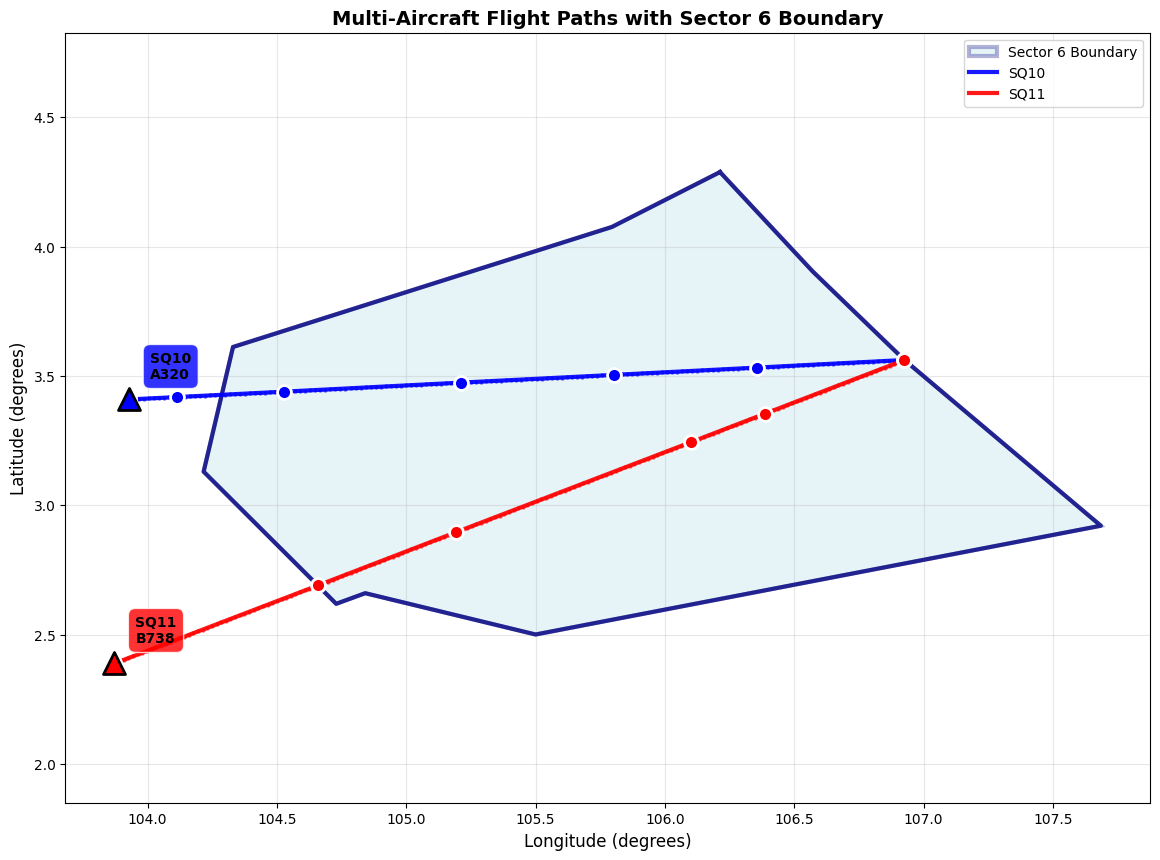

Adding sector boundary to animation with 11 points
Animation saved to: animation.gif


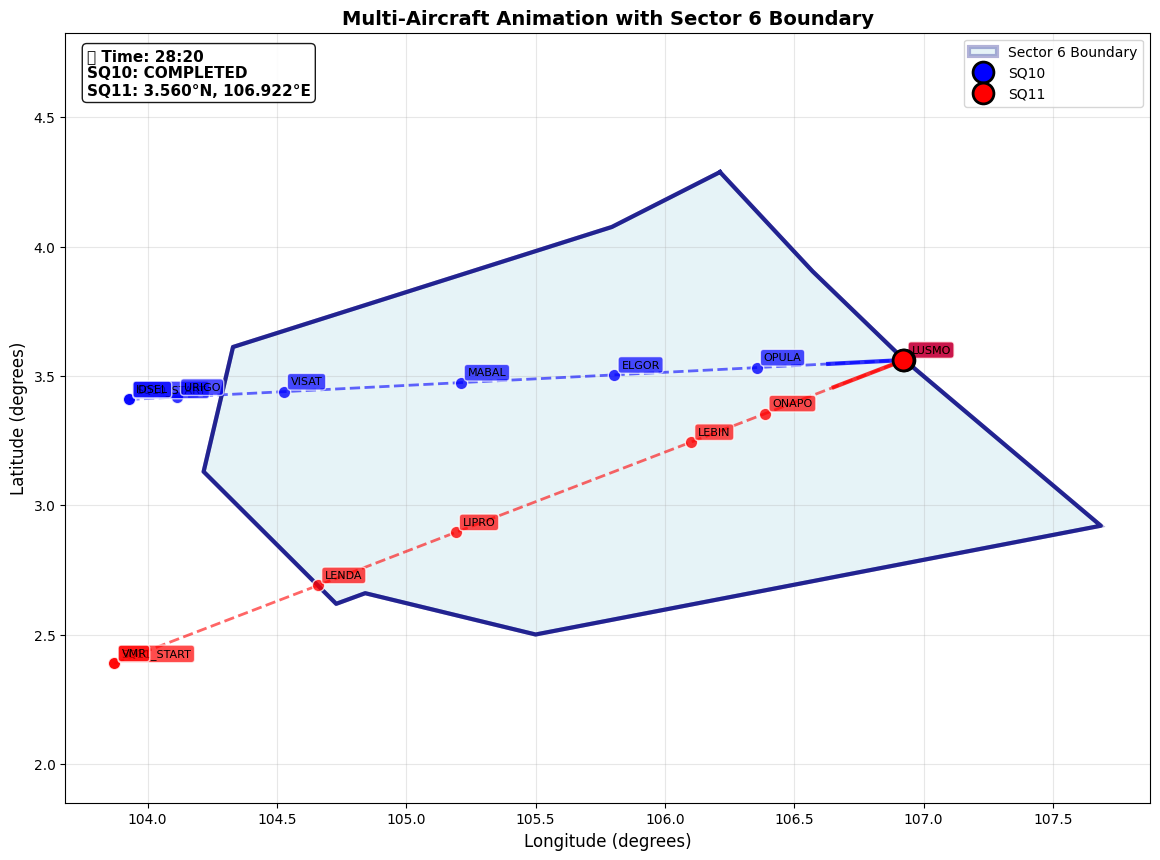

In [58]:
from Visualizer import MultiAircraftVisualizer, create_visualization
# visualizer = MultiAircraftVisualizer('SingaporeWaypoints.csv', 'sector6coords.csv')
# flight_plans = visualizer.parse_xml_flight_plans(b)
# all_flight_paths = visualizer.calculate_all_flight_paths(flight_plans)
from Visualizer import MultiAircraftVisualizer, create_visualization

# Method 1: Direct function call
# visualizer, flight_paths = create_visualization(xml_content, output_name='my_aircraft')

# Method 2: Manual approach
visualizer = MultiAircraftVisualizer('SingaporeWaypoints.csv', 'sector6coords.csv')
flight_plans = visualizer.parse_xml_flight_plans(b)
all_flight_paths = visualizer.calculate_all_flight_paths(flight_plans)
visualizer.create_static_plot(all_flight_paths)
visualizer.create_animation(all_flight_paths, save_path='animation.gif')



#semantic checks



In [65]:
from XMLchecker import TwoAircraftScenarioChecker, check_two_aircraft_xml

success, details = check_two_aircraft_xml(b, prompt=question)

🔍 TWO AIRCRAFT SCENARIO VALIDATION
📋 PROMPT: Generate a 2 aircraft scenario. Aircraft 1 on airway M758 and  aircraft 2 on airway N884. The first aircraft should start at time 100 seconds and the second aircraft starting at 300 seconds.

✈️  AIRCRAFT FOUND:
1. SQ10 (A320) starts at T+100s
   Route: IDSEL → URIGO → VISAT → MABAL → ELGOR → OPULA → LUSMO
2. SQ11 (B738) starts at T+300s
   Route: VMR → LENDA → LIPRO → LEBIN → ONAPO → LUSMO

🔢 CHECK 1: AIRCRAFT COUNT
✅ PASSED: Exactly 2 aircraft found

🛤️  CHECK 2: AIRWAY ASSIGNMENTS
✅ Aircraft 1 (SQ10): Correctly assigned to M758
✅ Aircraft 2 (SQ11): Correctly assigned to N884

⏰ CHECK 3: TIMING REQUIREMENTS
✅ First aircraft starts at 100 seconds: SQ10 at T+100s
✅ Second aircraft starts at 300 seconds: SQ11 at T+300s
ℹ️  Separation: 200 seconds (SQ10 → SQ11)

📊 SUMMARY:
• Aircraft Count: ✅ PASS
• Airway Assignment: ✅ PASS
• Timing: ✅ PASS

🎉 OVERALL RESULT: ALL REQUIREMENTS MET! ✅

🔬 DETAILED ANALYSIS:

✅ WHAT'S WORKING:
• Correct number of

### A basic front end for user convenience, made with GRADIO

In [1]:

# Define the chatbot function
def chatbot_response(user_input):
    try:
        chatbot_history.append(HumanMessage(content=user_input))
        extracted_docs = retriever.invoke(user_input)
        formatted_docs = format_docs(extracted_docs)
        response = chain.invoke({
            "context": formatted_docs,
            "chat_history": chatbot_history,
            "question": user_input
        })
        chatbot_history.append(AIMessage(content=response))
        return response, formatted_docs
    except Exception as e:
        error_message = f"Error: {str(e)}"
        return error_message, ""  # Always return a tuple

# Helper functions to save files
def save_raw_response(raw_response):
    with open("raw_response.txt", "w") as file:
        file.write(raw_response)
    return "raw_response.txt"

def save_dict_output(dict_result):
    with open("dict_output.json", "w") as file:
        file.write(dict_result)
    return "dict_output.json"

def save_xml_output(xml_result):
    with open("xml_output.xdat", "w") as file:
        file.write(xml_result)
    return "xml_output.xdat"
# DEFAULT_OUTPUT = "No output yet"
# Create the Gradio interface
with gr.Blocks() as chatbot_interface:
    with gr.Tabs():
        with gr.Tab("Chatbot"):
            gr.Markdown("### LangChain Agent Chatbot")
            chat_history = gr.Chatbot()
            user_input = gr.Textbox(label="Type your message here", placeholder="Ask me anything...", lines=1)
            send_button = gr.Button("Send")

            # Function to update the chat history
            def update_chat_history(history, input_text):
                # Get the response from the chatbot
                response,formatted_docs = chatbot_response(input_text)
                # Add the input and response to the chat history
                history.append((input_text, response))
                return history, gr.update(value=""), response, formatted_docs

            # Outputs: chat history and raw chatbot response
            raw_response = gr.Textbox(label="Raw Chatbot Response", visible=False)
            formatted_docs = gr.Textbox(label="Context Retrieved", visible=True)
            user_input.submit(
                update_chat_history,
                inputs=[chat_history, user_input],
                outputs=[chat_history, user_input, raw_response, formatted_docs]
            )
            send_button.click(
                update_chat_history,
                inputs=[chat_history, user_input],
                outputs=[chat_history, user_input, raw_response, formatted_docs]
            )
        with gr.Tab("Output Files"):
            gr.Markdown("### Post-Processed Output")
            #  formatted_docs_display = gr.Textbox(label="Context Retrieved", interactive=False, lines=10)
            raw_response_display = gr.Textbox(label="Raw Response", interactive=False, lines=10)
            dict_output = gr.Textbox(label="Dictionary Output", interactive=False, lines=10)
            xml_output = gr.Textbox(label="XML Output", interactive=False, lines=10)

            # Function to handle post-processing
            def post_process_response(raw_response):
                dict_result = str2dict(raw_response)
                xml_result = json_to_xml(dict_result)
                return raw_response, json.dumps(dict_result, indent=4), xml_result
                # return (
                #     raw_response or DEFAULT_OUTPUT,
                #     json.dumps(dict_result, indent=4) if dict_result else DEFAULT_OUTPUT,
                #     xml_result or DEFAULT_OUTPUT,
                # )

            # Trigger post-processing on new response
            raw_response.change(
                post_process_response,
                inputs=[raw_response],
                outputs=[raw_response_display, dict_output, xml_output]
            )

           # Download buttons
            gr.Markdown("### Download Outputs")
            download_raw_btn = gr.Button("Download Raw Response as Text")
            download_dict_btn = gr.Button("Download Dictionary as JSON")
            download_xml_btn = gr.Button("Download XML as XDAT")

            # Connect download buttons
            download_raw_btn.click(
                save_raw_response,
                inputs=[raw_response_display],
                outputs=gr.File()
            )
            download_dict_btn.click(
                save_dict_output,
                inputs=[dict_output],
                outputs=gr.File()
            )
            download_xml_btn.click(
                save_xml_output,
                inputs=[xml_output],
                outputs=gr.File()
            )
# Launch the interface
chatbot_interface.launch(debug=True)


NameError: name 'gr' is not defined